## **XGBoost**

데이터 세트는 일상 사용 시 무거운 Scania 트럭에서 수집된 데이터로 구성된다. 
이 시스템은 공기압 시스템(APS)으로, 제동 및 기어 변속과 같은 대차의 다양한 기능에 사용되는 가압 공기를 생성합니다. 
데이터 세트의 pos는 APS 시스템의 특정 구성 요소에 대한 구성 요소 장애로 구성됩니다. 
neg는 APS와 관련이 없는 구성 요소에 대한 고장이 있는 트럭으로 구성됩니다. 
데이터는 전문가들이 선택한 사용 가능한 모든 데이터의 하위 집합으로 구성됩니다.

* 학습 데이터 6만개 / 테스트 데이터 1만 6천개

In [1]:
import os
import numpy as np
import copy
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0630.git

Cloning into 'DX-Training-LGES-0630'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 68 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [3]:
# import dataset

train_data = pd.read_csv('/content/DX-Training-LGES-0630/Data/Data_XGBoost_APS_Sensor_Classification_train.csv')
test_data = pd.read_csv('/content/DX-Training-LGES-0630/Data/Data_XGBoost_APS_Sensor_Classification_test.csv')

del train_data['Unnamed: 0']
del test_data['Unnamed: 0']

train_data.head()

,aa_000,ac_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,label
0,45260.0,442.0,0.0,0.0,0.0,0.0,0.0,100422.0,1655688.0,1108034.0,...,121684.0,226718.0,184050.0,205394.0,858050.0,33222.0,0.0,0.0,0.0,0.0
1,60856.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15354.0,448202.0,...,208040.0,513504.0,563476.0,582422.0,384180.0,97252.0,0.0,0.0,0.0,0.0
2,47534.0,692.0,0.0,0.0,0.0,0.0,0.0,0.0,2070.0,233100.0,...,253092.0,552128.0,449354.0,133876.0,90004.0,175426.0,5278.0,0.0,0.0,0.0
3,79260.0,254.0,0.0,0.0,0.0,0.0,0.0,0.0,31538.0,764866.0,...,593040.0,1762706.0,671518.0,1872.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3144.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,7352.0,164006.0,...,5660.0,15358.0,20668.0,48802.0,31842.0,416.0,0.0,0.0,0.0,0.0


In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

X_train = train_data.iloc[:, 0:-1]; Y_train = train_data.iloc[:,-1]; X_test = test_data.iloc[:, 0:-1]; Y_test = test_data.iloc[:,-1] 

## XGboost
#### 파라미터 참조 : https://xgboost.readthedocs.io/en/stable/parameter.html

> GridSearchCV: 교차검증 (Cross-validation) + Hyperparameter Tuning

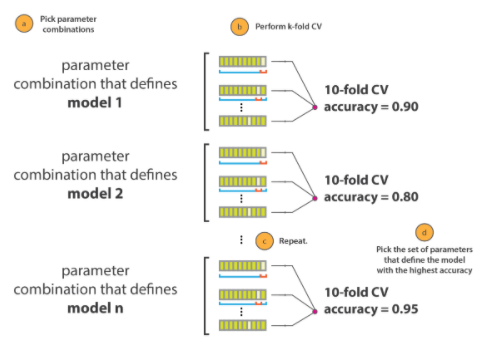

In [5]:
from xgboost import XGBClassifier

params = {"n_estimators" : [50, 100, 150], "max_depth" : [5, 10, 15]}

# model define
model_XG = XGBClassifier(use_label_encoder=False, objective = "binary:logistic", eval_metric = "error")

# model train with gridsearchCV
grid_model_XG = GridSearchCV(model_XG, param_grid = params, cv = 5, refit = True, return_train_score= True)
grid_model_XG.fit(X_train, Y_train)

# print results
result = pd.DataFrame(grid_model_XG.cv_results_)

best_model_XG = grid_model_XG.best_estimator_

In [6]:
print("CV score")
result[["params"] + ["split" + str(i) + "_test_score" for i in range(5)] + ["std_test_score", "mean_test_score"]]

CV score


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,std_test_score,mean_test_score
0,"{'max_depth': 5, 'n_estimators': 50}",0.986159,0.975779,0.982699,0.987024,0.982684,0.003961,0.982869
1,"{'max_depth': 5, 'n_estimators': 100}",0.983564,0.977509,0.980969,0.987889,0.985281,0.003569,0.983042
2,"{'max_depth': 5, 'n_estimators': 150}",0.983564,0.979239,0.980104,0.989619,0.987013,0.003966,0.983908
3,"{'max_depth': 10, 'n_estimators': 50}",0.982699,0.976644,0.979239,0.988754,0.985281,0.004285,0.982523
4,"{'max_depth': 10, 'n_estimators': 100}",0.982699,0.977509,0.980969,0.989619,0.987013,0.004306,0.983562
5,"{'max_depth': 10, 'n_estimators': 150}",0.984429,0.978374,0.980969,0.989619,0.987879,0.004179,0.984254
6,"{'max_depth': 15, 'n_estimators': 50}",0.983564,0.974913,0.979239,0.987024,0.985281,0.004389,0.982004
7,"{'max_depth': 15, 'n_estimators': 100}",0.986159,0.978374,0.980969,0.989619,0.987013,0.004129,0.984427
8,"{'max_depth': 15, 'n_estimators': 150}",0.985294,0.978374,0.980969,0.989619,0.988745,0.004354,0.984600


In [7]:
print("XGboost")
print("Best Parameter : " + str(grid_model_XG.best_params_))

# predict
pred = best_model_XG.predict(X_test)
# cross table
tab = pd.crosstab(Y_test, pred, rownames = ["real"], colnames = ["pred"])
print(tab)
print("Acc : " + str((tab.iloc[0, 0] + tab.iloc[1,1]) / len(X_test)))

XGboost
Best Parameter : {'max_depth': 15, 'n_estimators': 150}
pred    0.0  1.0
real            
0.0   14161   91
1.0      25  135
Acc : 0.9919511518179295


## Feature Importance (Top10)

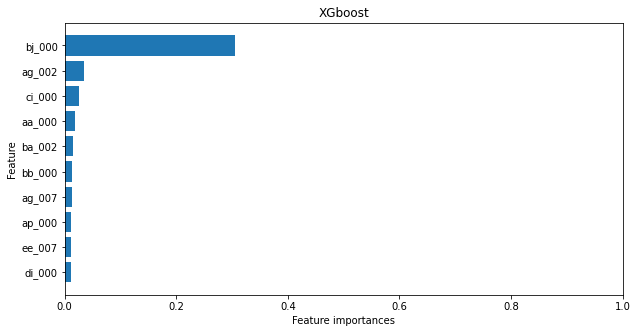

In [8]:
# visualie the feature importance

plt.figure(figsize = (10, 5))

plt.title("XGboost")
fi = best_model_XG.feature_importances_
idx = (-fi).argsort()[0:10]
fi = fi[idx]
idx = X_train.columns[idx]
plt.barh(range(10), fi[::-1], align='center')
plt.xlim(0, 1)
plt.yticks(range(10), idx[::-1])
plt.xlabel('Feature importances', size=10)
plt.ylabel('Feature', size=10)

plt.show() 